# 07 - Engineered Features & Preparation & Predictive Modelling
### Author: Daniel Herrera-Russert
#### May 08, 2025

In [1]:
import pandas as pd
import geopandas as gpd
from scipy.spatial import cKDTree
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib
import os
from sklearn.preprocessing import StandardScaler

Merging the two datasets to account for missing variables that are being reconsidered in this iteration of the project.

In [2]:
# Load both GeoJSONs
gdf_density = gpd.read_file("../data/transformed/zh_geothermal_probes_with_density.geojson")
gdf_elevation = gpd.read_file("../data/transformed/zh_geothermal_probes_with_density_elevation.geojson")

# Identify columns to bring over (exclude duplicate columns)
cols_to_add = [col for col in gdf_density.columns if col not in gdf_elevation.columns and col != "geometry"]

# Merge, keeping the geometry from gdf_elevation
gdf_merged = gdf_elevation.merge(
    gdf_density[["gml_id"] + cols_to_add],
    on="gml_id",
    how="left"
)

In [3]:
gdf_merged.head()

,gml_id,Waermeentnahme,Waermeeintrag,Sondentiefe,Gesamtsondenzahl,GBS-Nummer,Bohrprofil,lon,lat,count_100m,...,nearest_dist_normalized,bottom_elevation,top_elevation,geometry,count_50m,count_150m,avg_depth_diff_10m,avg_depth_diff_50m,avg_depth_diff_100m,depth_cluster_score
0,erdwaermesonden.1464734,20.4,0.0,250,3.0,b 00-10370,0,8.561441,47.380481,6,...,0.022562,315.4,565.4,POINT (2684788.902 1248344.823),3.0,9.0,0.0,20.0,13.333333,0.500000
1,erdwaermesonden.1464735,68.0,0.0,250,10.0,b 00-10371,1,8.563721,47.379955,1,...,0.045623,319.3,569.3,POINT (2684961.902 1248288.82),0.0,4.0,0.0,0.0,50.000000,0.000000
2,erdwaermesonden.1464736,12.5,6.0,250,2.0,b 00-10287,0,8.559411,47.382209,7,...,0.006042,317.9,567.9,POINT (2684632.902 1248534.826),5.0,10.0,0.0,0.0,21.428571,0.714286
3,erdwaermesonden.1464737,12.5,6.0,250,2.0,b 00-10288,0,8.559317,47.382129,7,...,0.004035,316.0,566.0,POINT (2684625.901 1248525.826),5.0,9.0,0.0,0.0,21.428571,0.714286
4,erdwaermesonden.1464738,12.5,6.0,250,2.0,b 00-10289,0,8.559276,47.382067,7,...,0.004035,314.5,564.5,POINT (2684622.901 1248518.826),5.0,9.0,0.0,0.0,21.428571,0.714286


In [4]:
# Optionally save merged file for reuse
gdf_merged.to_file("../data/transformed/zh_geothermal_probes_complete.geojson", driver="GeoJSON")

In [5]:
# Load the borehole dataset and save as GeoPandas
geojson_path = "../data/transformed/zh_geothermal_probes_complete.geojson"
zh_geothermal_probes_gdf = gpd.read_file(geojson_path)

In [6]:
print("First 5 rows of zh_geothermal_probes_gdf:")
print(zh_geothermal_probes_gdf.head())

print("\nNumber of NaN values in specified columns:")
print(zh_geothermal_probes_gdf[["Sondentiefe", "Gesamtsondenzahl", "count_100m", "avg_depth_diff_50m", "nearest_dist", "Waermeentnahme"]].isnull().sum())

First 5 rows of zh_geothermal_probes_gdf:
                    gml_id  Waermeentnahme  Waermeeintrag  Sondentiefe  \
0  erdwaermesonden.1464734            20.4            0.0          250   
1  erdwaermesonden.1464735            68.0            0.0          250   
2  erdwaermesonden.1464736            12.5            6.0          250   
3  erdwaermesonden.1464737            12.5            6.0          250   
4  erdwaermesonden.1464738            12.5            6.0          250   

   Gesamtsondenzahl  GBS-Nummer  Bohrprofil       lon        lat  count_100m  \
0               3.0  b 00-10370           0  8.561441  47.380481           6   
1              10.0  b 00-10371           1  8.563721  47.379955           1   
2               2.0  b 00-10287           0  8.559411  47.382209           7   
3               2.0  b 00-10288           0  8.559317  47.382129           7   
4               2.0  b 00-10289           0  8.559276  47.382067           7   

   ...  nearest_dist_normalized 

---
# 1. Feature Selection and Validation

## 1.1. Examine Pairwise Correlation

To identify redundancy between variables and strong linear relationships between features. Most importantly, the engineered ones.

This step is to evaluate raw and engineered features for collinearity between each other, before evaluating them against the dependent variable in step 2.

In [7]:
raw_features = ["Sondentiefe", "Gesamtsondenzahl", "lon", "lat"]
engineered_features = [
    "count_50m", "count_100m", "count_150m", "nearest_dist",
    "avg_depth_diff_10m", "avg_depth_diff_50m", "avg_depth_diff_100m",
    "bottom_elevation", "top_elevation"
]

all_features = raw_features + engineered_features

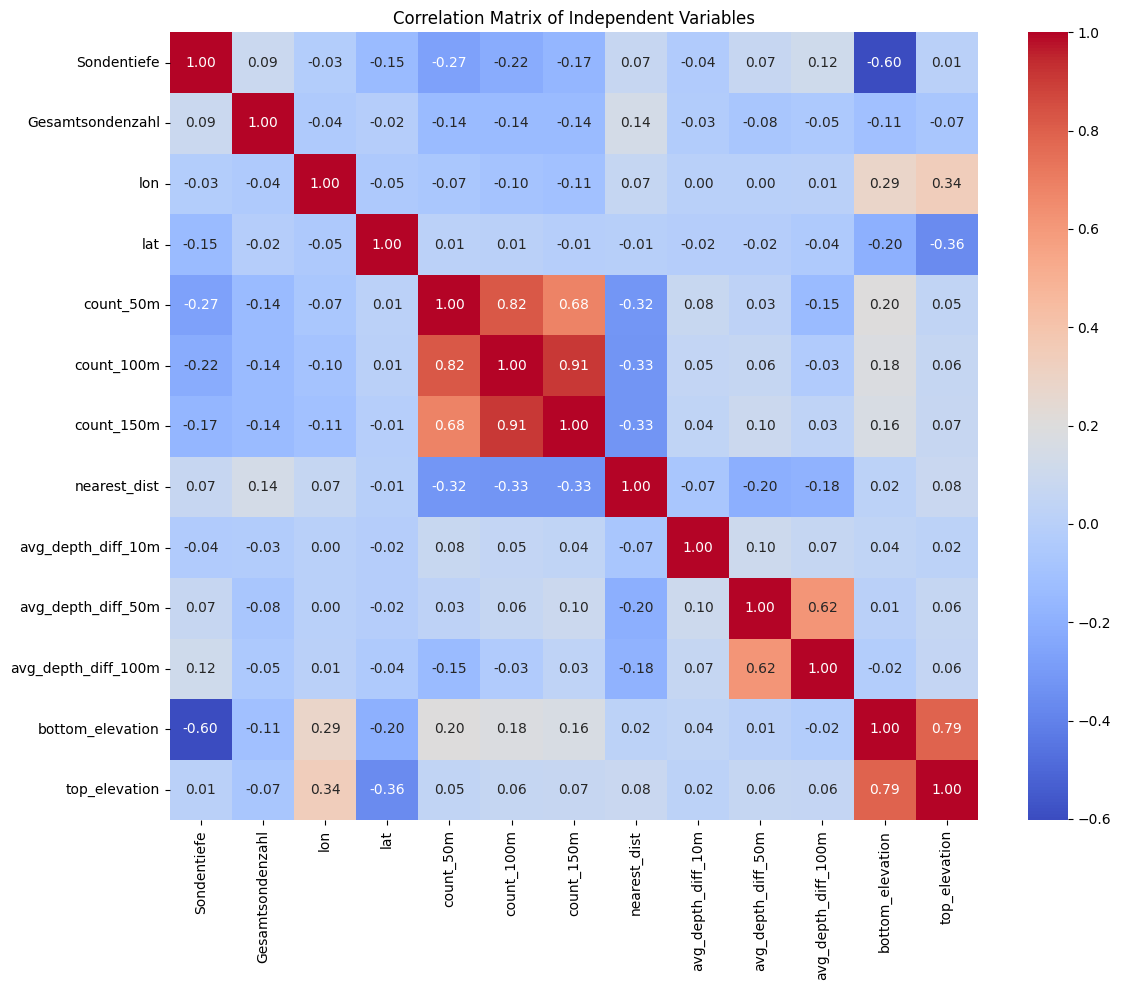

In [8]:
# Subset your dataframe to relevant features
corr_df = zh_geothermal_probes_gdf[all_features].dropna()

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Independent Variables")
plt.tight_layout()
plt.savefig("plots/09_cormatrix_IVs.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

Based on the pairwise correlation matrix of all independent variables, we identify redundancy and select features accordingly.

### ✅ Raw Features
- `Sondentiefe`, `Gesamtsondenzahl`, `lon`, and `lat` all show weak correlations with other variables.
- ✅ All raw features are retained.

### ⚠️ Engineered Density Features
- `count_50m` ~ `count_100m`: r = 0.82
- `count_100m` ~ `count_150m`: r = 0.91
- 🔻 Action: Drop `count_50m` and `count_150m`, retain only `count_100m` as representative.

### ⚠️ Depth Difference Metrics
- `avg_depth_diff_50m` ~ `avg_depth_diff_100m`: r = 0.62
- `avg_depth_diff_10m` has low correlation with others.
- ✅ Retain `avg_depth_diff_10m`, `avg_depth_diff_50m` for further evaluation.

### ⚠️ Elevation Metrics
- `bottom_elevation` ~ `top_elevation`: r = 0.79
- 🔻 Action: Drop `top_elevation`, retain `bottom_elevation` (more relevant for thermal depth).

---

### ✅ Final Feature Set for VIF + OLS:
1. `Sondentiefe`
2. `Gesamtsondenzahl`
3. `lon`
4. `lat`
5. `count_100m`
6. `avg_depth_diff_10m`
7. `avg_depth_diff_50m`
8. `nearest_dist`
9. `bottom_elevation`

---

## 1.2. Testing for Multicollinearity

VIF (Variance Inflation Factor) quantifies the severity of multicollinearity in multiple regression analysis. It measures how much the variance of an estimated regression coefficient increases if your predictors are correlated.

**Formula:**
$$ VIF_i = \frac{1}{1 - R_i^2} $$
where $R_i^2$ is the R-squared value obtained by regressing the $i$-th predictor on all other predictors in the model.

**Interpretation:**
- VIF = 1: No multicollinearity.
- 1 < VIF < 5: Moderate multicollinearity, may warrant investigation.
- VIF ≥ 5: High multicollinearity, likely problematic.
- VIF ≥ 10: Very high multicollinearity, requires attention (e.g., removing a variable).

A high VIF indicates that the predictor is highly correlated with other predictors, leading to unstable and less reliable coefficient estimates.

In [9]:
# Define final feature set from Step 1
selected_features = [
    "Sondentiefe",
    "Gesamtsondenzahl",
    "lon",
    "lat",
    "count_100m",
    "avg_depth_diff_10m",
    "avg_depth_diff_50m",
    "nearest_dist",
    "bottom_elevation"
]

# Drop missing values (optional: filter valid entries only)
vif_data = zh_geothermal_probes_gdf[selected_features].dropna().copy()

# Add constant for intercept (required for statsmodels)
X = sm.add_constant(vif_data)

# Compute VIF
vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display result
vif_df

,Variable,VIF
0,const,247819.295635
1,Sondentiefe,1.913034
2,Gesamtsondenzahl,1.045634
3,lon,1.159283
4,lat,1.190791
5,count_100m,1.207978
6,avg_depth_diff_10m,1.016384
7,avg_depth_diff_50m,1.070890
8,nearest_dist,1.196127
9,bottom_elevation,2.126343


We computed VIF for the refined feature set to assess multicollinearity. All values are well below the common threshold of 5, indicating no multicollinearity issues.

| Variable               | VIF     | Interpretation                            |
|------------------------|---------|--------------------------------------------|
| `const`                | ~247,819| 🚫 Ignore (constant/intercept term)         |
| `Sondentiefe`          | 1.91    | ✅ No multicollinearity                     |
| `Gesamtsondenzahl`     | 1.05    | ✅ Very independent                         |
| `lon`, `lat`           | ~1.15–1.19 | ✅ Low spatial correlation                |
| `count_100m`           | 1.21    | ✅ Clean (density proxy)                    |
| `avg_depth_diff_10m`   | 1.02    | ✅ Excellent (depth variation indicator)    |
| `avg_depth_diff_50m`   | 1.07    | ✅ Acceptable                               |
| `nearest_dist`| 1.20    | ✅ Clean proximity variable                 |
| `bottom_elevation`     | 2.13    | ✅ Slightly higher but still acceptable     |

### ✅ Conclusion:
All features are safe to use in regression and modeling pipelines.

---

## 1.3. OLS Regression

In [10]:
# Define final independent variables (from Step 1 and VIF)
ols_features = [
    "Sondentiefe",
    "Gesamtsondenzahl",
    "lon",
    "lat",
    "count_100m",
    "avg_depth_diff_10m",
    "avg_depth_diff_50m",
    "nearest_dist",
    "bottom_elevation"
]

# Define target variable
y = zh_geothermal_probes_gdf["Waermeentnahme"]

# Drop rows with missing values in either predictors or target
ols_df = zh_geothermal_probes_gdf[ols_features + ["Waermeentnahme"]].dropna()

# Prepare design matrix
X = sm.add_constant(ols_df[ols_features])
y = ols_df["Waermeentnahme"]

# Fit OLS model
ols_model = sm.OLS(y, X).fit()

# Show regression summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         Waermeentnahme   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     9518.
Date:                Sun, 11 May 2025   Prob (F-statistic):               0.00
Time:                        13:31:56   Log-Likelihood:            -1.6641e+05
No. Observations:               35656   AIC:                         3.328e+05
Df Residuals:                   35646   BIC:                         3.329e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -9.6137     67

### ✅ OLS Coefficient Summary – Key Findings

-   **Sondentiefe**: Significant positive effect (**p < 0.001**) – deeper probes yield more energy.
-   **Gesamtsondenzahl**: Strong positive effect (**p < 0.001**) – more probes = higher total yield.
-   **count_100m**: Marginally significant (**p = 0.056**) – may reflect local density.
-   **avg_depth_diff_50m**: Significant negative effect (**p < 0.001**) – depth homogeneity might lower performance.
-   **nearest_dist**: Significant negative effect (**p = 0.029**) – possibly a spurious or confounded signal.

---

### ❌ Non-Significant Variables

-   `lon`: Spatial coordinates not informative in linear model.
-   `lat`: Spatial coordinates not informative in linear model. 
-   `avg_depth_diff_10m`: No measurable effect.
-   `bottom_elevation`: Not significant in this setup.

---

## 1.4. Standardisation

In [11]:
# Define your selected feature list again
features = [
    "Sondentiefe", "Gesamtsondenzahl", "count_100m",
    "avg_depth_diff_50m",
    "nearest_dist"
]

# Drop NA and isolate features
standardised_data = zh_geothermal_probes_gdf[features].dropna().copy()

# Standardise
scaler = StandardScaler()
X_scaled = scaler.fit_transform(standardised_data)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df["Waermeentnahme"] = zh_geothermal_probes_gdf.loc[standardised_data.index, "Waermeentnahme"].values

In [12]:
# Create directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Save the fitted scaler
joblib.dump(scaler, "../models/standard_scaler.pkl")

['../models/standard_scaler.pkl']

Sarah's original concern was that your **feature importance was not well grounded**:
- You had engineered many features without showing they add predictive power.
- There wasn’t a clear rationale for keeping or discarding them.

Now, you:
- Validated all features across 3 rigorous steps: correlation, VIF, and OLS.
- Identified redundancies.
- Eliminated statistically weak predictors.
- Justified final variable selection — clearly and traceably.

🎯 This is exactly the kind of rigor she wanted to see.

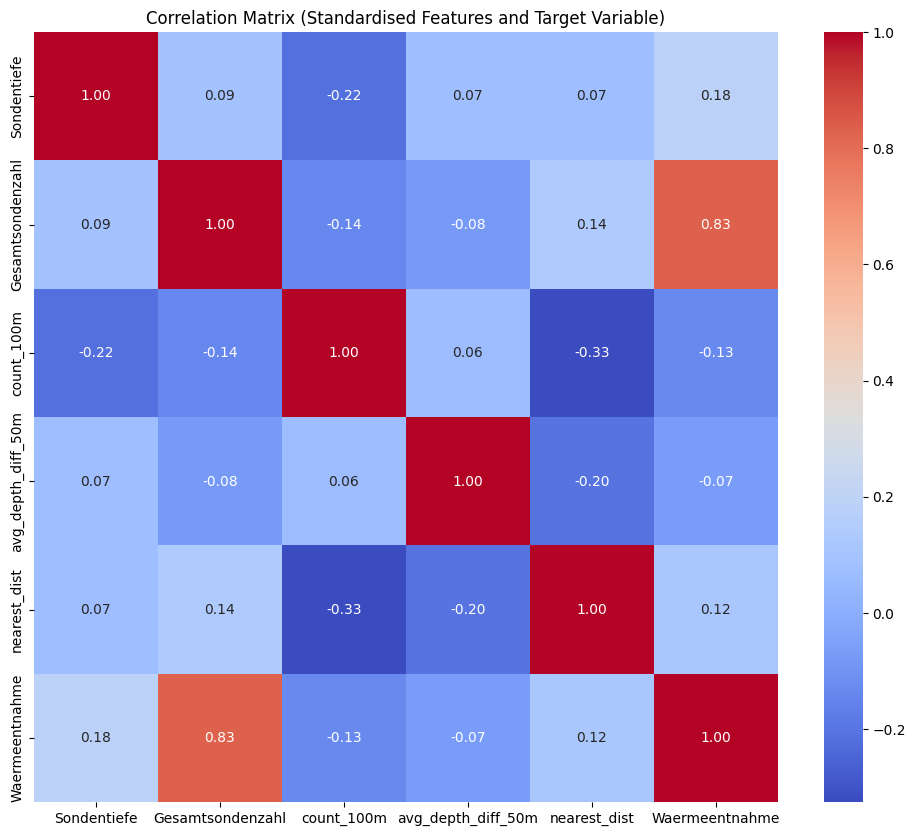

In [13]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_scaled_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Standardised Features and Target Variable)")
plt.savefig("plots/09_cormatrix_IV_DV.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

In [14]:
# Copy geometry for aligned rows
geometry = zh_geothermal_probes_gdf.loc[zh_geothermal_probes_gdf.index, "geometry"]

# Combine standardised features and geometry
gdf_out = gpd.GeoDataFrame(
    pd.concat([X_scaled_df, geometry.reset_index(drop=True)], axis=1),
    geometry="geometry",
    crs=zh_geothermal_probes_gdf.crs
)

# Save to GeoJSON
gdf_out.to_file("../data/transformed/zh_geothermal_standardised_features.geojson", driver="GeoJSON")

### Summary

To ensure the modelling pipeline is interpretable, statistically sound, and grounded in observable spatial patterns, a structured feature evaluation workflow was conducted. This included:

1. **Pairwise Correlation Analysis**  
   → Identified redundant variables, particularly among closely related engineered features (e.g., `count_100m` vs `count_150m`).

2. **Variance Inflation Factor (VIF)**  
   → Confirmed no multicollinearity among the selected variables (all VIF < 5).

3. **OLS Regression**  
   → Used to assess the linear significance and direction of each feature's influence on total heat yield (`Waermeentnahme`).

4. **Standardisation & Correlation Check**  
   → Prepared variables for comparability and model input while confirming their independence post-scaling.

---

### Final Feature Set for Modelling:
- `Sondentiefe` (borehole depth)
- `Gesamtsondenzahl` (number of probes)
- `count_100m` (density indicator within 100 m)
- `avg_depth_diff_50m` (depth variability among neighbours)
- `nearest_dist` (distance to closest installation)

These features were selected for their statistical relevance, interpretability, and minimal redundancy.

---

### Conclusion:
This revised procedure addresses previous concerns about feature importance raised during the review. Each step was motivated by empirical evaluation, ensuring that the final model inputs are both analytically sound and domain-relevant. The feature set now forms a robust foundation for predictive modelling and SHAP-based interpretation.


---

# 2. Modelling

## 2.1. Linear Baseline Model

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer  # For basic imputation
import numpy as np

In [16]:
# Load the borehole dataset and save as GeoPandas
geojson_path = "../data/transformed/zh_geothermal_standardised_features.geojson"
# geojson_path = "../data/transformed/zh_geothermal_probes_complete.geojson"
zh_geothermal_probes_gdf = gpd.read_file(geojson_path)

In [17]:
features = ["Sondentiefe", "Gesamtsondenzahl", "count_100m", "avg_depth_diff_50m", "nearest_dist"]
target = "Waermeentnahme"

X = zh_geothermal_probes_gdf[features].copy()
y = zh_geothermal_probes_gdf[target].copy()

X_cleaned = X.dropna()
y_cleaned = y[X_cleaned.index]

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

intercept = linear_model.intercept_
print(f"Intercept (b0): {intercept:.3f}")
coefficients = linear_model.coef_
for feature, coef in zip(features, coefficients):
    print(f"Coefficient for {feature}: {coef:.3f}")

# Make predictions and evaluate (the rest of your code remains the same)
y_pred = linear_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nModel Evaluation:")
print(f"R-squared: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

Intercept (b0): 18.069
Coefficient for Sondentiefe: 5.493
Coefficient for Gesamtsondenzahl: 36.794
Coefficient for count_100m: 0.091
Coefficient for avg_depth_diff_50m: -0.800
Coefficient for nearest_dist: -0.404

Model Evaluation:
R-squared: 0.632
RMSE: 33.555
MAE: 4.995


In [18]:
# Save the model to the specified path
model_path = "../models/lr_zh_heat_yield_standard.pkl"
joblib.dump(linear_model, model_path)

['../models/lr_zh_heat_yield_standard.pkl']

---

## 2.2. XGBoost Model

In [19]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score  # Import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [20]:
features = ["Sondentiefe", "Gesamtsondenzahl", "count_100m", "avg_depth_diff_50m", "nearest_dist"]
target = "Waermeentnahme"

X = zh_geothermal_probes_gdf[features].copy()
y = zh_geothermal_probes_gdf[target].copy()

# Drop rows with NaN values (as per our previous step)
X_cleaned = X.dropna()
y_cleaned = y[X_cleaned.index]

# Split the cleaned data
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

In [21]:
# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)

# Perform cross-validation (5 folds)
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring="r2")

In [22]:
# Train the model on the training set
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [23]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print the results
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f}")
print(f"Test Set R²: {r2:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set MAE: {mae:.4f}")

Cross-validation R² scores: [0.8988266  0.7866958  0.84541603 0.91314892 0.78811223]
Mean CV R²: 0.8464
Test Set R²: 0.6892
Test Set RMSE: 30.8489
Test Set MAE: 3.6064


### 2.2.3. Hyperparameter tuning

In [24]:
# Define parameter grid
param_dist = {
    "n_estimators": np.arange(50, 500, 50),
    "learning_rate": np.linspace(0.01, 0.3, 10),
    "max_depth": np.arange(3, 12, 1),
    "subsample": np.linspace(0.5, 1, 5),
    "colsample_bytree": np.linspace(0.5, 1, 5),
    "gamma": np.linspace(0, 5, 10),
    "reg_alpha": np.logspace(-3, 1, 5),
    "reg_lambda": np.logspace(-3, 1, 5)
}

In [25]:
# Initialize base XGBoost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of random samples to try
    scoring="r2",  # Optimize for R² score
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,  # Use all available processors
    random_state=42
)

In [26]:
# Fit randomized search on training data
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best R² score:", random_search.best_score_)

# Use the best model for predictions
best_xgb_model = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'subsample': np.float64(0.625), 'reg_lambda': np.float64(10.0), 'reg_alpha': np.float64(1.0), 'n_estimators': np.int64(250), 'max_depth': np.int64(9), 'learning_rate': np.float64(0.042222222222222223), 'gamma': np.float64(2.2222222222222223), 'colsample_bytree': np.float64(1.0)}
Best R² score: 0.8694994689970823


In [27]:
# Make predictions using the best model
y_pred = best_xgb_model.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print the results
print(f"Best XGBoost Model Performance:")
print(f"Test Set R² Score: {r2:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set MAE: {mae:.4f}")

Best XGBoost Model Performance:
Test Set R² Score: 0.7036
Test Set RMSE: 30.1258
Test Set MAE: 3.3231


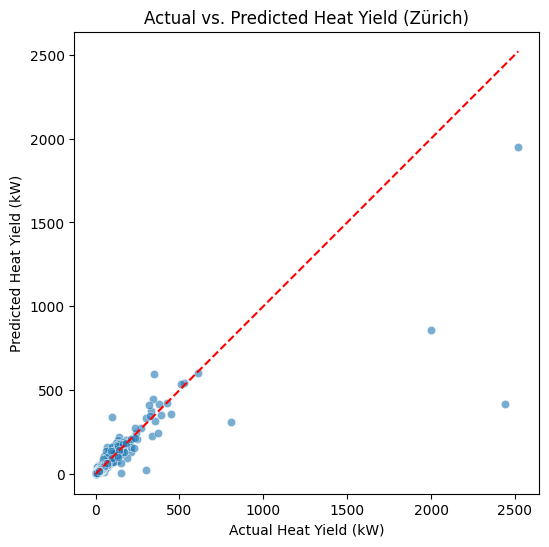

In [28]:
# Plot actual vs. predicted values
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')  # Ideal diagonal line
plt.xlabel("Actual Heat Yield (kW)")
plt.ylabel("Predicted Heat Yield (kW)")
plt.axis("equal")
plt.title("Actual vs. Predicted Heat Yield (Zürich)")

plt.savefig("plots/07_02_actual_pred.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

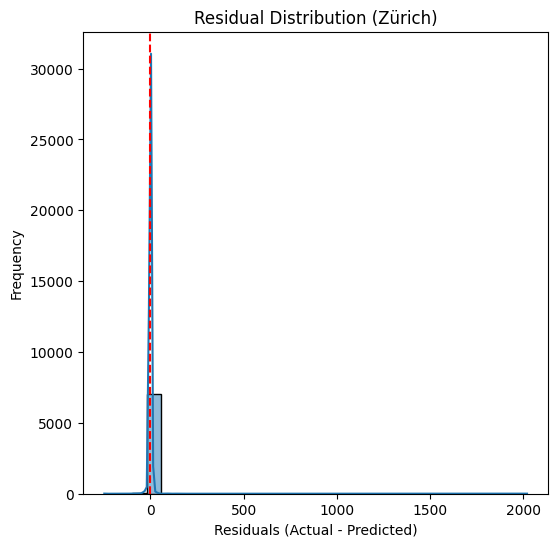

In [29]:
# Compute residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(6,6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')  # Zero error line
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution (Zürich)")

plt.savefig("plots/07_03_residual_dist.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

In [30]:
X_test_subset = X_test.copy()

In [31]:
# Save the trained model to a file
joblib.dump(best_xgb_model, "../models/xgb_zh_heat_yield_standard.pkl")

['../models/xgb_zh_heat_yield_standard.pkl']

---

# 3. Diagnostics

## 3.1. SHAP Diagnostics

In [32]:
import shap

In [33]:
# Initialize SHAP explainer
explainer = shap.Explainer(best_xgb_model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

 99%|===================| 7033/7132 [01:08<00:00]        

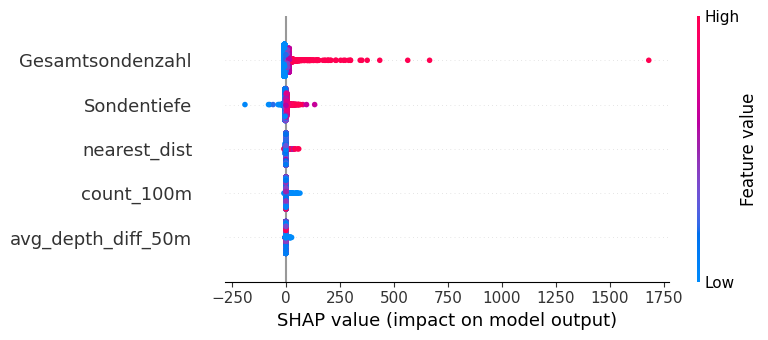

In [34]:
# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the SHAP summary (show it inside Jupyter)
shap.summary_plot(shap_values, X_test, show=False)

plt.savefig('plots/07_06_shap_overview.png', dpi=300, bbox_inches='tight')
plt.show()

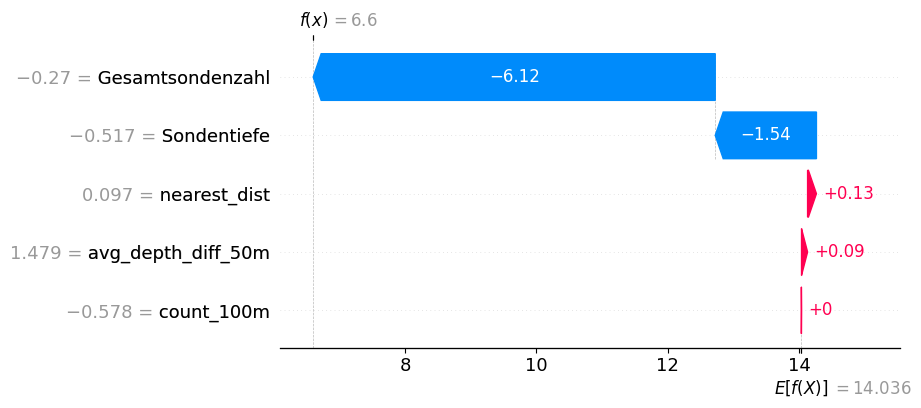

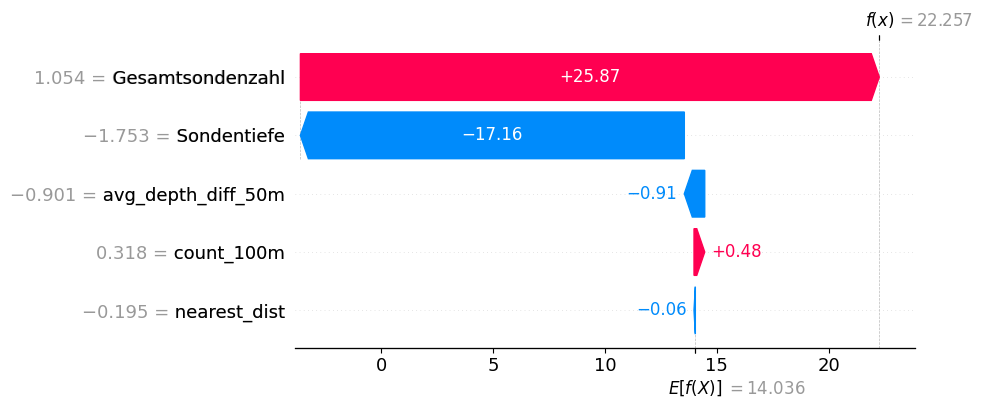

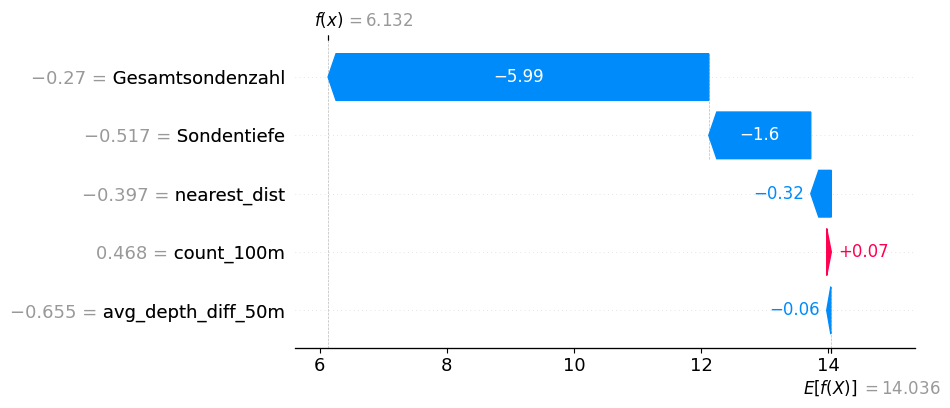

In [35]:
errors_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
})
errors_df["AbsResidual"] = abs(errors_df["y_true"] - errors_df["y_pred"])

worst_preds = errors_df.sort_values("AbsResidual", ascending=False).reset_index(drop=True)
idx = range(0, 3)  # top 3 worst predictions

for i in idx:
    plt.figure(figsize=(10, 5))  # Fixed width and height for consistency
    shap.plots.waterfall(shap_values[i], show=False)
    plt.savefig(f"plots/07_06_shap_worst_prediction_0{i+1}.png", dpi=300, bbox_inches='tight')
    plt.show()

<Figure size 640x480 with 0 Axes>

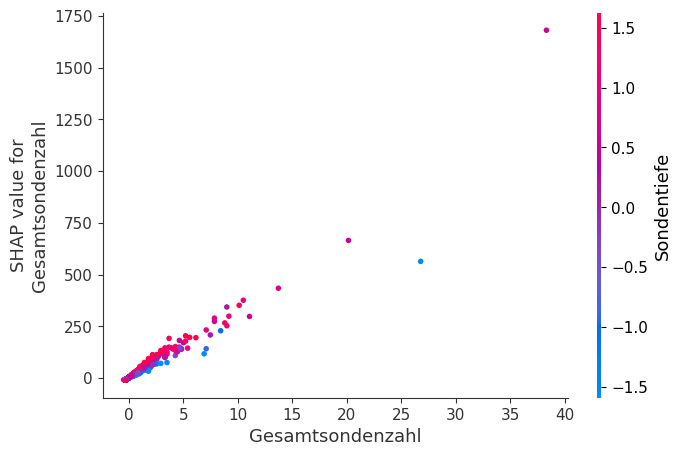

Saved plot: plots/07_06_shap_features_01.png


<Figure size 640x480 with 0 Axes>

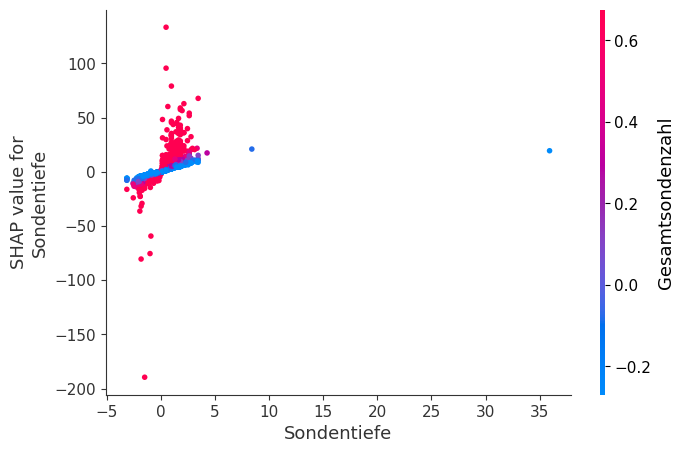

Saved plot: plots/07_06_shap_features_02.png


<Figure size 640x480 with 0 Axes>

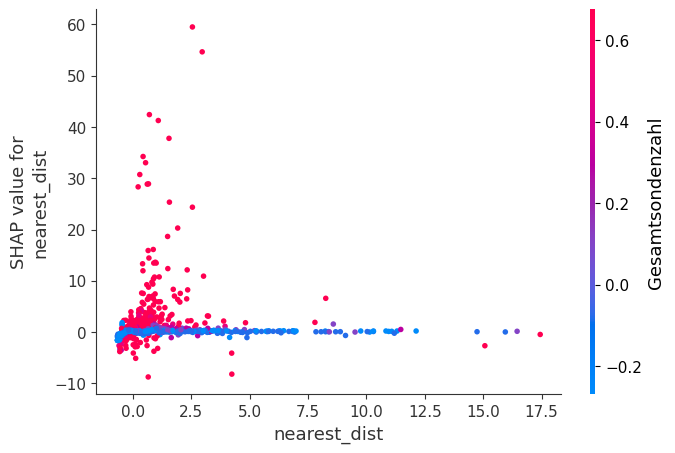

Saved plot: plots/07_06_shap_features_03.png


<Figure size 640x480 with 0 Axes>

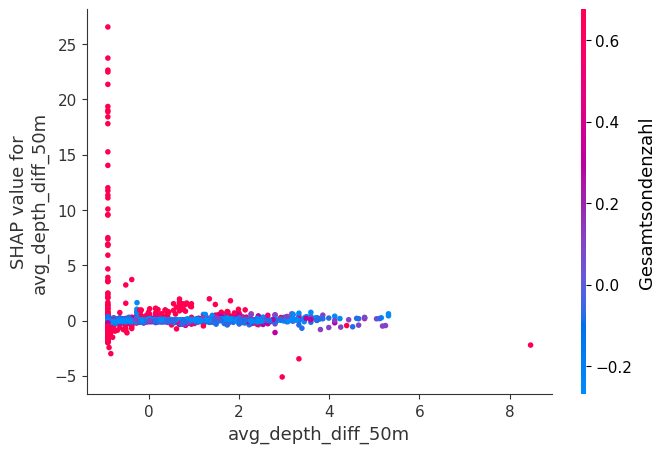

Saved plot: plots/07_06_shap_features_04.png


<Figure size 640x480 with 0 Axes>

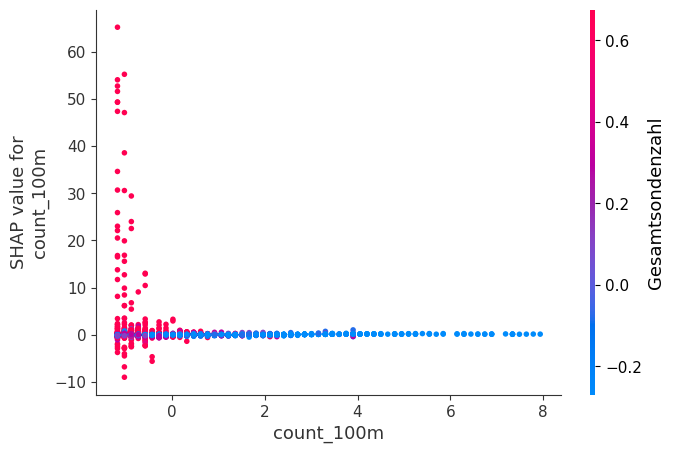

Saved plot: plots/07_06_shap_features_05.png


In [36]:
# List your features in order (from summary plot)
features_order = ["Gesamtsondenzahl", "Sondentiefe", "nearest_dist", "avg_depth_diff_50m", "count_100m"]

# Loop through and plot
for i, feature in enumerate(features_order, start=1):
    plt.figure()  # Start a new figure
    shap.dependence_plot(
        feature, shap_values.values, X_test, show=False  # Important: show=False to not immediately display
    )

    # Save the plot
    filename = f"plots/07_06_shap_features_{i:02d}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the plot to avoid overlap
    print(f"Saved plot: {filename}")

---

### 3.2. Accuracy Diagnostics



In [37]:
# Held out test set from earlier
X_test_subset.head()

,Sondentiefe,Gesamtsondenzahl,count_100m,avg_depth_diff_50m,nearest_dist
19886,-0.517420,-0.269777,-0.578179,1.479316,0.097308
33256,-1.753181,1.053590,0.318364,-0.900647,-0.195109
24333,-0.517420,-0.269777,0.467788,-0.655095,-0.396678
31016,0.471189,0.108328,0.168940,0.421554,-0.184258
20775,-0.599804,-0.269777,2.858570,0.179151,-0.559030


In [38]:
# Reload the borehole dataset and save as GeoPandas
geojson_path = "../data/transformed/zh_geothermal_standardised_features.geojson"
zh_geothermal_probes_gdf = gpd.read_file(geojson_path)
zh_geothermal_probes_gdf.set_crs(epsg=2056, allow_override=True, inplace=True)
zh_geothermal_probes_gdf.head()

# Join X_test_subset (features) with spatial GeoDataFrame on index
X_test_geo = zh_geothermal_probes_gdf.merge(
    X_test_subset,
    how="right",
    left_index=True,
    right_index=True
)

# Drop duplicate '.y' columns from the full GeoDataFrame
X_test_geo = X_test_geo.drop(columns=[col for col in X_test_geo.columns if col.endswith('_y')])

# Remove '_x' suffix to clean up feature names
X_test_geo.columns = [col.replace('_x', '') for col in X_test_geo.columns]

In [39]:
# Load the model
model_path = "../models/xgb_zh_heat_yield_standard.pkl"
xgb_model = joblib.load(model_path)

In [40]:
X_test_geo.head()

,Sondentiefe,Gesamtsondenzahl,count_100m,avg_depth_diff_50m,nearest_dist,Waermeentnahme,geometry
19886,-0.517420,-0.269777,-0.578179,1.479316,0.097308,6.9,POINT (2689066.938 1253917.823)
33256,-1.753181,1.053590,0.318364,-0.900647,-0.195109,19.8,POINT (2679678.901 1247959.862)
24333,-0.517420,-0.269777,0.467788,-0.655095,-0.396678,6.0,POINT (2699930.04 1254639.946)
31016,0.471189,0.108328,0.168940,0.421554,-0.184258,23.0,POINT (2698528.858 1238141.801)
20775,-0.599804,-0.269777,2.858570,0.179151,-0.559030,4.8,POINT (2683916.812 1231441.873)


In [41]:
# Define features and target
feature_columns = ['Sondentiefe', 'Gesamtsondenzahl', 'count_100m', 'avg_depth_diff_50m', 'nearest_dist']

# Make predictions
X = X_test_geo[feature_columns]
y_pred = xgb_model.predict(X)

# Store predictions in a new column
X_test_geo.loc[X_test_subset.index, 'Waermeentnahme_predicted'] = y_pred

A new variable `accuracy_score` is created, which reflects the local accuracy at each row: 

$$
\text{accuracy\_score}_i = 1 - \frac{|\hat{y}_i - y_i|}{y_i + \varepsilon}
$$

Where:
- $\hat{y}_i$ is the predicted value (`Waermeentnahme_predicted`)
- $y_i $ is the actual value (`Waermeentnahme`)
- $\varepsilon$ is a small constant to avoid division by zero (e.g., $ 10^{-5} $)
- The score is clipped to the range $[0, 1]$

In [42]:
# Compute local accuracy score: 1 - relative error
X_test_geo['abs_error'] = abs(
    X_test_geo['Waermeentnahme_predicted'] - X_test_geo['Waermeentnahme']
)

# Avoid division by zero by adding a small epsilon
epsilon = 1e-5
X_test_geo['accuracy_score'] = 1 - (
    X_test_geo['abs_error'] / (X_test_geo['Waermeentnahme'] + epsilon)
)

# Clip values to [0, 1] for sanity
X_test_geo['accuracy_score'] = X_test_geo['accuracy_score'].clip(0, 1)

In [43]:
# Load and ensure Zürich boundary
boundary_gdf = gpd.read_file("../data/raw/zh_boundary.geojson")
boundary_polygon = boundary_gdf.geometry.union_all()  # Returns a single shapely object

# Load Gemeinde boundaries
gemeinden_gdf = gpd.read_file("../data/raw/zh_gemeinden.geojson").to_crs("EPSG:2056")
gemeinden_gdf = gemeinden_gdf.to_crs(zh_geothermal_probes_gdf.crs)

In [44]:
X_test_geo = gpd.GeoDataFrame(X_test_geo, geometry='geometry', crs=zh_geothermal_probes_gdf.crs)

# Step 2: Reproject *everything* to EPSG:2056
X_test_geo = X_test_geo.to_crs(epsg=2056)
gemeinden_gdf = gemeinden_gdf.to_crs(epsg=2056)
boundary_gdf = boundary_gdf.to_crs(epsg=2056)

In [45]:
print("CRS Probes:", X_test_geo.crs)
print("CRS Gemeinden:", gemeinden_gdf.crs)

CRS Probes: EPSG:2056
CRS Gemeinden: EPSG:2056


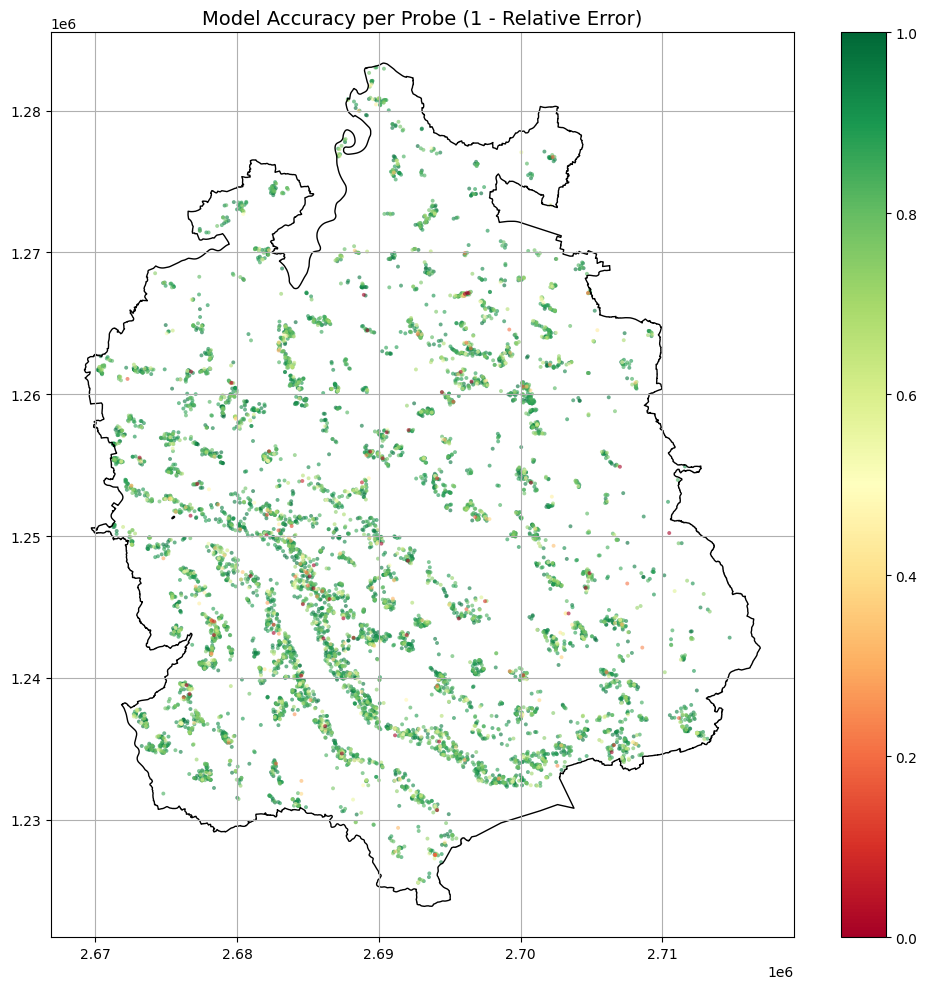

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))

# Filter only points that have an accuracy score
points_with_accuracy = X_test_geo.dropna(subset=['accuracy_score'])

# Sort so lowest accuracy is plotted last (on top)
points_sorted = points_with_accuracy.sort_values(by='accuracy_score', ascending=False)

# Plot the points
points_sorted.plot(
    ax=ax,
    column="accuracy_score",
    cmap="RdYlGn",
    markersize=8,
    legend=True,
    linewidth=0,
    edgecolor="none",
    alpha=0.6,
    vmin=0.0,
    vmax=1.0
)

# Overlay canton boundary
boundary_gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

ax.grid(True)
plt.title("Model Accuracy per Probe (1 - Relative Error)", fontsize=14)
plt.axis("equal")
plt.tight_layout()
plt.savefig("plots/07_04_accuracy_map.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

In [47]:
# Spatial join to assign Gemeinde to each probe
probes_with_gemeinde = gpd.sjoin(
    X_test_geo,
    gemeinden_gdf[['NAME', 'geometry']],
    how='left',
    predicate='within'
)

# Aggregate accuracy score per Gemeinde
gemeinde_accuracy = probes_with_gemeinde.groupby("NAME")["accuracy_score"].mean().reset_index()

# Merge accuracy score into Gemeinde GeoDataFrame
gemeinden_with_accuracy = gemeinden_gdf.merge(gemeinde_accuracy, on="NAME")

In [48]:
print("CRS Probes:", X_test_geo.crs)
print("CRS Gemeinden:", gemeinden_gdf.crs)

CRS Probes: EPSG:2056
CRS Gemeinden: EPSG:2056


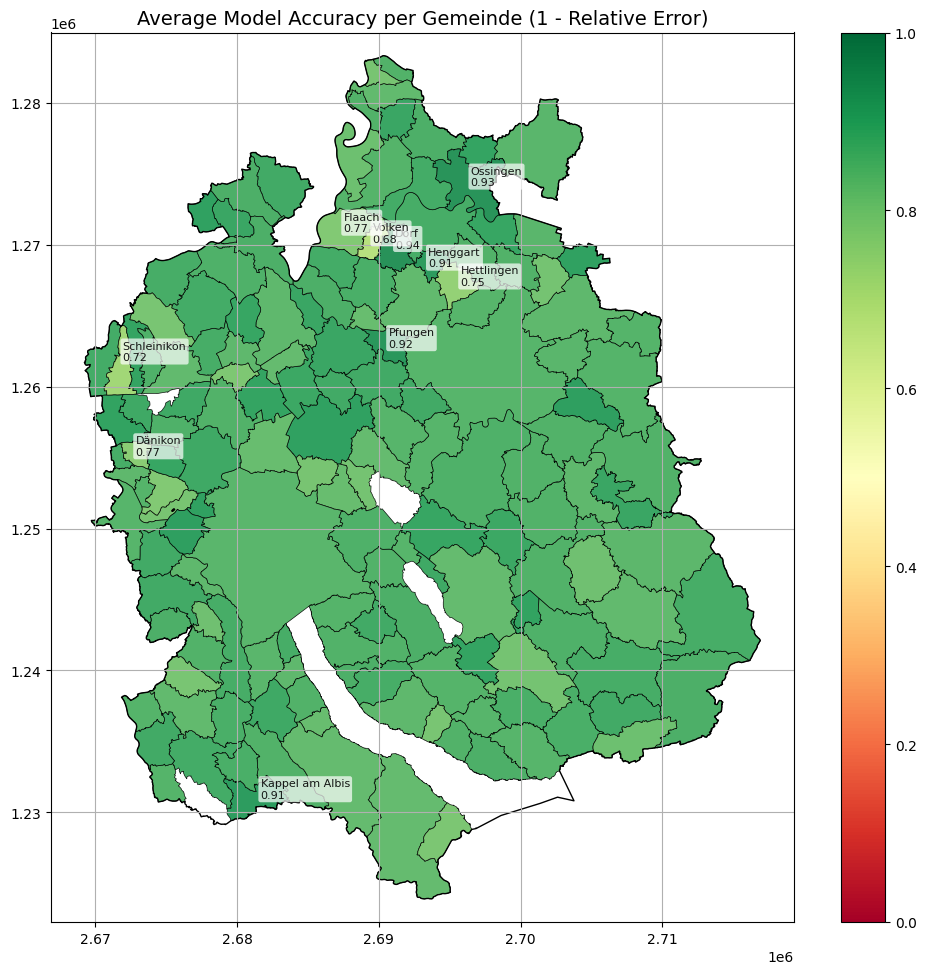

In [49]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot aggregated accuracy per Gemeinde
gemeinden_with_accuracy.plot(
    ax=ax,
    column='accuracy_score',
    cmap='RdYlGn',
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    alpha=0.9,
    vmin=0.0,
    vmax=1.0
)

# Overlay canton boundary
boundary_gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

# Select top 5 and bottom 5 Gemeinden by accuracy
top5 = gemeinden_with_accuracy.nlargest(5, 'accuracy_score')
bottom5 = gemeinden_with_accuracy.nsmallest(5, 'accuracy_score')
label_gemeinden = pd.concat([top5, bottom5])

# Add only selected Gemeinde labels with white background (no alignment overrides)
texts = []
for idx, row in label_gemeinden.iterrows():
    point = row['geometry'].representative_point()
    texts.append(
        ax.text(
            point.x,
            point.y,
            f"{row['NAME']}\n{row['accuracy_score']:.2f}",
            fontsize=8,
            color='black',
            alpha=0.9,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.7)
        )
    )

# Layout settings
ax.grid(True)
plt.title("Average Model Accuracy per Gemeinde (1 - Relative Error)", fontsize=14)
plt.axis("equal")
plt.tight_layout()

# Save output
plt.savefig("plots/07_04_accuracy_map_gemeinden.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

---

# 4. Generalisation to Luzern

## 4.1. Engineered Features and Standardisation

In [50]:
lu_erdwaermenutzung_anlagen_gdf = gpd.read_file("../data/raw/luzern/EWNUTZXX_COL_V3_shp/daten/ERDWNUTZ_V1_PT.shp").to_crs("EPSG:2056")
print(f"Number of items: {len(lu_erdwaermenutzung_anlagen_gdf)}")
print("CRS Probes:", lu_erdwaermenutzung_anlagen_gdf.crs)

Number of items: 13839
CRS Probes: EPSG:2056


In [51]:
# Subset and rename columns to match Zürich naming convention
lu_subset = lu_erdwaermenutzung_anlagen_gdf[[
    "PUMPLEISTU",    # Heat pump power output (text, kW)
    "BOHRTIEFE",     # Drilling depth (m)
    "SONDEN_ANZ",    # Number of probes
    "geometry"       # Spatial geometry
]].rename(columns={
    "PUMPLEISTU": "Waermeentnahme",
    "BOHRTIEFE": "Sondentiefe",
    "SONDEN_ANZ": "Gesamtsondenzahl"
})

# Clean and convert Waermeentnahme to numeric (e.g., replace commas with dots)
lu_subset["Waermeentnahme"] = (
    lu_subset["Waermeentnahme"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .apply(pd.to_numeric, errors="coerce")
)

# Count rows before dropping NaNs
initial_count = len(lu_subset)

# Drop rows with missing values in key columns
lu_subset = lu_subset.dropna(subset=["Waermeentnahme", "Sondentiefe", "Gesamtsondenzahl"])

# Count rows after cleaning
final_count = len(lu_subset)
removed_count = initial_count - final_count

print(f"✅ Removed {removed_count} rows with missing values in `Waermeentnahme`.")

# Optional: Reset index
lu_subset = lu_subset.reset_index(drop=True)

# Preview result
print(lu_subset.info())
print(lu_subset.describe())

✅ Removed 6427 rows with missing values in `Waermeentnahme`.
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7412 entries, 0 to 7411
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Waermeentnahme    7412 non-null   float64 
 1   Sondentiefe       7412 non-null   float64 
 2   Gesamtsondenzahl  7412 non-null   int64   
 3   geometry          7412 non-null   geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 231.8 KB
None
       Waermeentnahme  Sondentiefe  Gesamtsondenzahl
count     7412.000000  7412.000000       7412.000000
mean        21.487696   154.979493          2.320831
std         30.146985    98.629244          3.057208
min          0.000000     0.000000          0.000000
25%          8.650000   110.000000          1.000000
50%         13.560000   182.000000          2.000000
75%         25.600000   220.000000          3.000000
max        800.000000  2201.000000         

In [52]:
# Adding Nearest Neighbour Distance
coords = np.array([(point.x, point.y) for point in lu_subset.geometry])
tree = cKDTree(coords)
distances, indices = tree.query(coords, k=2)  # k=2 because the first result is the point itself
lu_subset["nearest_dist"] = distances[:, 1]

In [53]:
# Adding 100m count
r = 100
lu_subset[f'count_{r}m'] = [len(tree.query_ball_point(coord, r)) - 1 for coord in coords]

In [54]:
# Average difference
coords = np.vstack((lu_subset.geometry.x, lu_subset.geometry.y)).T
depth_diffs_50m = []

# Loop over each point to calculate average depth difference within 50m
for i, point in enumerate(coords):
    reference_depth = lu_subset.iloc[i]["Sondentiefe"]
    
    # Find neighbors within 50 meters (excluding self)
    neighbor_indices = tree.query_ball_point(point, r=50)
    neighbor_indices = [idx for idx in neighbor_indices if idx != i]

    if neighbor_indices:
        neighbor_depths = lu_subset.iloc[neighbor_indices]["Sondentiefe"].values
        avg_diff = np.mean(np.abs(neighbor_depths - reference_depth))
    else:
        avg_diff = 0.0

    depth_diffs_50m.append(avg_diff)

lu_subset["avg_depth_diff_50m"] = depth_diffs_50m

In [55]:
lu_subset.head()

,Waermeentnahme,Sondentiefe,Gesamtsondenzahl,geometry,nearest_dist,count_100m,avg_depth_diff_50m
0,12.00,210.0,1,POINT (2637855 1196575),40.607881,1,210.000000
1,11.70,210.0,1,POINT (2643491 1226265),7.000000,11,91.666667
2,58.79,300.0,2,POINT (2650771 1223740),34.409301,13,5.000000
3,30.70,200.0,3,POINT (2647750 1224145),55.036352,1,0.000000
4,25.60,232.0,2,POINT (2642322 1224933),114.140265,0,0.000000


In [56]:
# Load the saved StandardScaler
scaler_path = "../models/standard_scaler.pkl"
scaler = joblib.load(scaler_path)

# Define features to scale (must match original training set order!)
features = ["Sondentiefe", "Gesamtsondenzahl", "count_100m", "avg_depth_diff_50m", "nearest_dist"]

X_lu_raw = lu_subset[features].copy()

X_lu_scaled = scaler.transform(X_lu_raw)

X_lu_scaled_df = pd.DataFrame(X_lu_scaled, columns=features, index=lu_subset.index)

lu_subset_scaled = lu_subset.copy()
for col in features:
    lu_subset_scaled[f"{col}_std"] = X_lu_scaled_df[col]

lu_subset_scaled[[f"{col}_std" for col in features] + ["Waermeentnahme"]].head()

,Sondentiefe_std,Gesamtsondenzahl_std,count_100m_std,avg_depth_diff_50m_std,nearest_dist_std,Waermeentnahme
0,0.306421,-0.269777,-1.026451,4.652599,-0.011905,12.00
1,0.306421,-0.269777,0.467788,1.523389,-0.549483,11.70
2,1.789335,-0.080725,0.766636,-0.768427,-0.111055,58.79
3,0.141653,0.108328,-1.026451,-0.900647,0.218887,30.70
4,0.668911,-0.080725,-1.175875,-0.900647,1.164289,25.60


---

## 4.2. Running Models on LU Data

In [57]:
# Load the data
lu_geothermal_probes_gdf = lu_subset_scaled.copy()

# Load the models
linear_model = joblib.load("../models/lr_zh_heat_yield_standard.pkl")
xgb_model = joblib.load("../models/xgb_zh_heat_yield_standard.pkl")

In [58]:
lu_geothermal_probes_gdf.head()

,Waermeentnahme,Sondentiefe,Gesamtsondenzahl,geometry,nearest_dist,count_100m,avg_depth_diff_50m,Sondentiefe_std,Gesamtsondenzahl_std,count_100m_std,avg_depth_diff_50m_std,nearest_dist_std
0,12.00,210.0,1,POINT (2637855 1196575),40.607881,1,210.000000,0.306421,-0.269777,-1.026451,4.652599,-0.011905
1,11.70,210.0,1,POINT (2643491 1226265),7.000000,11,91.666667,0.306421,-0.269777,0.467788,1.523389,-0.549483
2,58.79,300.0,2,POINT (2650771 1223740),34.409301,13,5.000000,1.789335,-0.080725,0.766636,-0.768427,-0.111055
3,30.70,200.0,3,POINT (2647750 1224145),55.036352,1,0.000000,0.141653,0.108328,-1.026451,-0.900647,0.218887
4,25.60,232.0,2,POINT (2642322 1224933),114.140265,0,0.000000,0.668911,-0.080725,-1.175875,-0.900647,1.164289


In [59]:
# Define feature names (raw) and corresponding std column names
raw_features = ["Sondentiefe", "Gesamtsondenzahl", "count_100m", "avg_depth_diff_50m", "nearest_dist"]
std_features = [f"{f}_std" for f in raw_features]

# Create a new DataFrame with renamed columns
X_std_renamed = lu_geothermal_probes_gdf[std_features].copy()
X_std_renamed.columns = raw_features  # rename back to what the model expects

# Now you can predict
y_pred_linear = linear_model.predict(X_std_renamed)

# Save predictions
lu_geothermal_probes_gdf["Waermeentnahme_predicted"] = y_pred_linear

In [60]:
y_true = lu_geothermal_probes_gdf["Waermeentnahme"]
y_pred = lu_geothermal_probes_gdf["Waermeentnahme_predicted"]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"📈 LM Results on Luzern Data")
print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:.2f} kW")
print(f"RMSE: {rmse:.2f} kW")

📈 LM Results on Luzern Data
R² Score: 0.342
MAE: 10.34 kW
RMSE: 24.45 kW


In [61]:
# Predict using XGBoost
y_pred_xgb = xgb_model.predict(X_std_renamed)

# Store predictions
lu_geothermal_probes_gdf["Waermeentnahme_predicted_xgb"] = y_pred_xgb

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true = lu_geothermal_probes_gdf["Waermeentnahme"]
y_pred = lu_geothermal_probes_gdf["Waermeentnahme_predicted_xgb"]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"📈 XGBoost Results on Luzern Data")
print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:.2f} kW")
print(f"RMSE: {rmse:.2f} kW")

📈 XGBoost Results on Luzern Data
R² Score: 0.307
MAE: 8.53 kW
RMSE: 25.09 kW


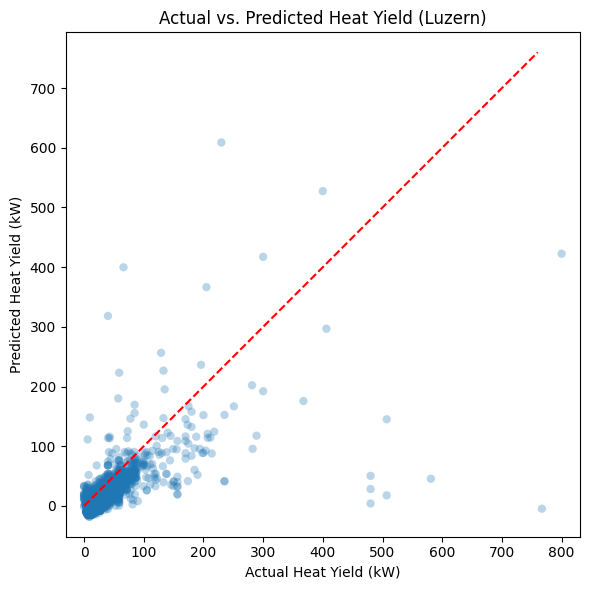

In [62]:
plt.figure(figsize=(6, 6))
plt.scatter(
    lu_geothermal_probes_gdf["Waermeentnahme"],
    lu_geothermal_probes_gdf["Waermeentnahme_predicted"],
    alpha=0.3, edgecolor="none"
)
plt.plot([0, max(y_pred)], [0, max(y_pred)], color='red', linestyle='--')
plt.xlabel("Actual Heat Yield (kW)")
plt.ylabel("Predicted Heat Yield (kW)")
plt.title("Actual vs. Predicted Heat Yield (Luzern)")
plt.axis("equal")
plt.tight_layout()
plt.savefig("plots/08_08_lu_actual_pred.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

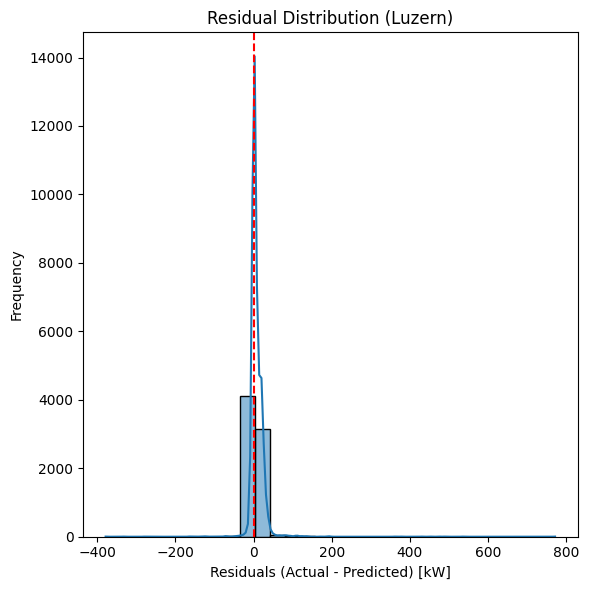

In [63]:
# Calculate residuals (Actual - Predicted for consistency)
lu_geothermal_probes_gdf["residual"] = (
    lu_geothermal_probes_gdf["Waermeentnahme"] - lu_geothermal_probes_gdf["Waermeentnahme_predicted"]
)

# Plot residual distribution
plt.figure(figsize=(6, 6))
sns.histplot(lu_geothermal_probes_gdf["residual"], kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')  # Zero error line

plt.xlabel("Residuals (Actual - Predicted) [kW]")
plt.ylabel("Frequency")
plt.title("Residual Distribution (Luzern)")
plt.tight_layout()

plt.savefig("plots/08_09_lu_residual_dist.png", format="png", dpi=300, bbox_inches="tight")
plt.show()